<img src="img/header.png"></img>

In [5]:
%load_ext autoreload
%autoreload 2 

import numpy as np
import pandas as pd
import seaborn as sns

# Auxiliar functions
from functions import plot_relationship, get_low_cardinality
from functions import get_missing, get_rsquares,  custom_boxplot, find_best_k
from functions import score_dataset, make_mi_scores, drop_uninformative
from functions import generate_submission_file, plot_variance, corrplot

# Custom column transformers
from transformers import FillWith, FillByKNN, FillByGroup

from transformers import FixTypos, CategorizeNominal, DropCols
from transformers import FloatToInt, EncodeCategories, ConvertToInt

from transformers import BuildMathFeatures, BuildInteractionsFeatures
from transformers import BuildCountsFeatures, BuildGroupFeatures, BuildCluster, BuildPCA

# Pipelines and model
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from xgboost import XGBRegressor

# Flag to plot graphics or not
# Prints slow the notebook execution.
PLOT = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
## Download data from kaggle
# from util import get_data
# get_data()


## 1. Exploratory Data Analysis

### 1.1 Data Preview

In [7]:
train = pd.read_csv("data/train.csv", index_col="Id")
X, y = train.drop("SalePrice", axis=1), train.pop("SalePrice")
X_test = pd.read_csv("data/test.csv", index_col="Id")


In [8]:
train.head(4)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml


In [9]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### 1.2 Filters

In [10]:
cat_cols = train.columns[train.dtypes == "object"]
num_cols = train.columns[train.dtypes == "int64"]
float_cols = train.columns[train.dtypes == "float"]

## Some of numeric data are categorical too, so i'll transfer from numeric list to categorical list
low_card_cols = get_low_cardinality(train[num_cols], 10)
num_cols = num_cols.drop(low_card_cols)
cat_cols = cat_cols.append(pd.Index(low_card_cols.keys()))


Categorical variables

In [11]:
train[cat_cols].head(2)


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,PoolArea,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,1,0,2,1,3,1,0,2,0,2008
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,0,1,2,0,3,1,1,2,0,2007


Numerical discrete variables

In [12]:
train[num_cols].head(2)


,MSSubClass,LotArea,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GrLivArea,TotRmsAbvGrd,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,8450,2003,2003,706,0,150,856,856,854,...,1710,8,548,0,61,0,0,0,0,2
2,20,9600,1976,1976,978,0,284,1262,1262,0,...,1262,6,460,298,0,0,0,0,0,5


Numerical continuous variables

In [13]:
train[float_cols].head(2)


,LotFrontage,MasVnrArea,GarageYrBlt
Id,,,
1,65.0,196.0,2003.0
2,80.0,0.0,1976.0


### 1.3 Mutual Information

MI score can give us an idea of how much information about hour target _SalePrice_ each _feature_ has.

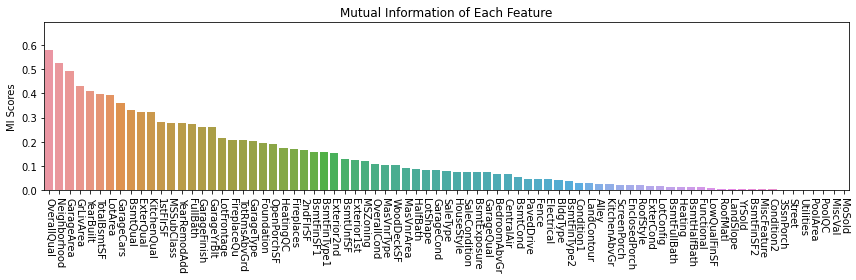

In [14]:
if PLOT:
    mi_scores = make_mi_scores(X.fillna(0), y)
    plot_relationship(mi_scores, "Mutual Information of Each Feature")


The farther from zero it is, the more information it can provide about our target. In this dataset, features like **OverallQual**, **Neighbornhood**, **GrLivArea**, **GarageArea**, **YearBuilt** and **ExternalQual** are good candidates for predictiors to **SalePrice**. On the other hand, **MoSold** (Month Sold) and **PoolIQC** (Pool Quality) don**t seem to be good predictors candidates.

### 1.4 Correlation

Correlation is a measures of **linear** association between two variables. Positive values indicate direct relationship, negative values indicate a inverse relationship.

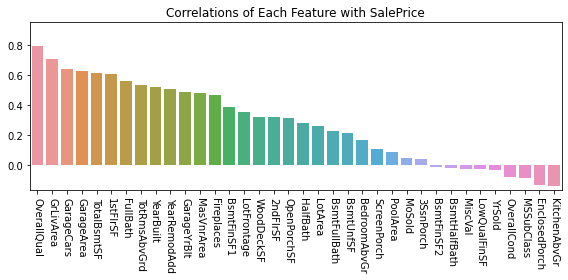

In [15]:
if PLOT:
    correlations = X.corrwith(y).sort_values(ascending=False)
    plot_relationship(correlations, "Correlations of Each Feature with SalePrice")


The **OverallQual**, **GrLivArea** and **TotalBsmtSF** has strong correlation with **SalePrice**

Despite Correlation represents the linear association, different distribuitions of data can have the same correlation without the data even following the regression curve. So i'll take a look to the regression graphics and check if the correlations are good.

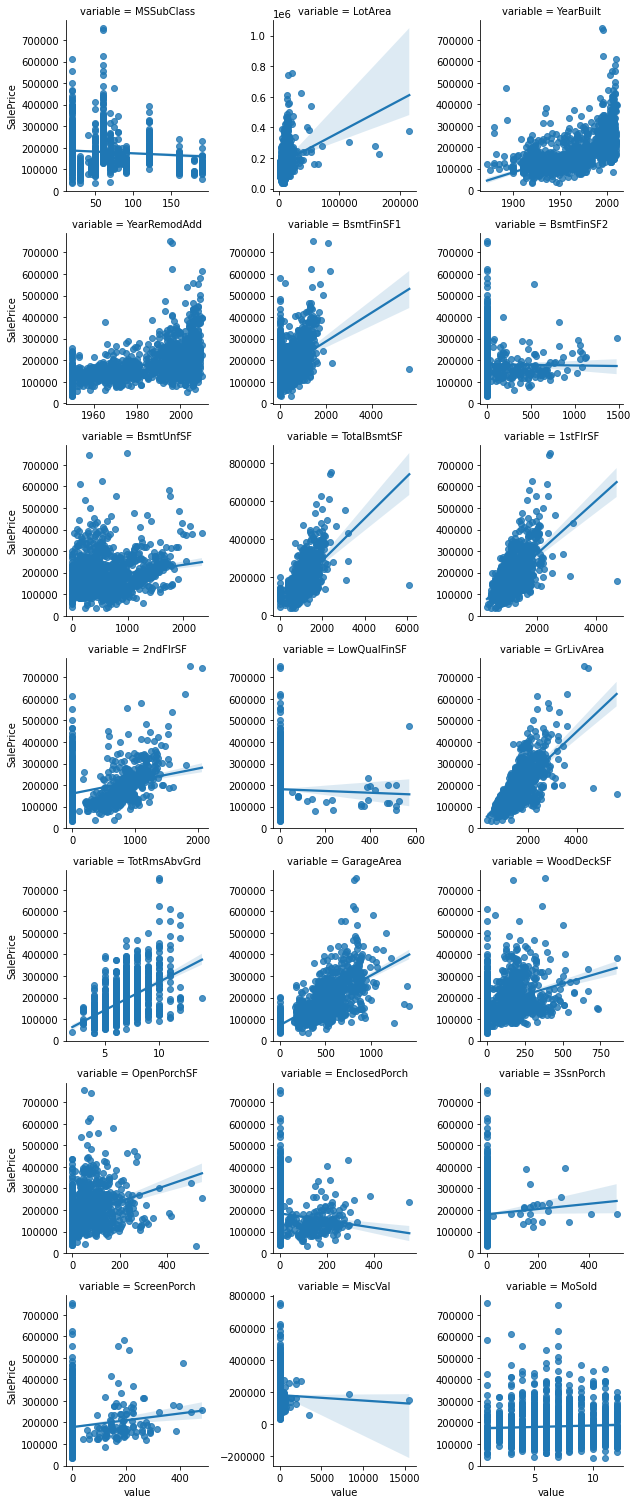

In [16]:
if PLOT:
    fg = pd.melt(
        X.join(y).fillna(0),
        id_vars=["SalePrice"],
        value_vars=X.join(y).fillna(0)[num_cols],
    )
    g = sns.FacetGrid(
        fg, col="variable", col_wrap=3, sharex=False, sharey=False, height=3
    )
    g.map(sns.regplot, "value", "SalePrice")


As you can see 'LotArea', 'MiscVal', and 'ScreenPorch' correlations are not reliable, although the correlation has values different from 0, the data distribuition don't follow the regression line.

### 1.5 R-square

Such as correlation, we can measure the degree of association between categorical variables and hour target. through the R-square we can measure how much variation of **SalePrice** is explained by hour features.

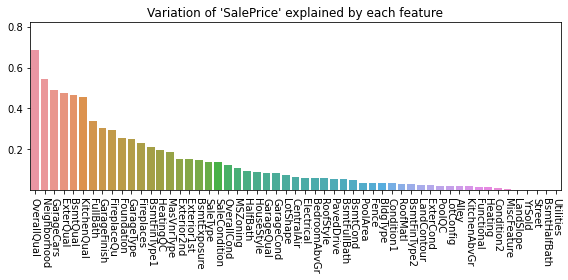

In [17]:
if PLOT:
    rsquares = get_rsquares(X[cat_cols], y).sort_values(ascending=False)
    plot_relationship(rsquares, "Variation of 'SalePrice' explained by each feature")


**OverallQual**, **Neighbornhood**, and **ExerQual** explain more than 50% from variation of **SalePrice**. Lets take a look to theese categorical variables.

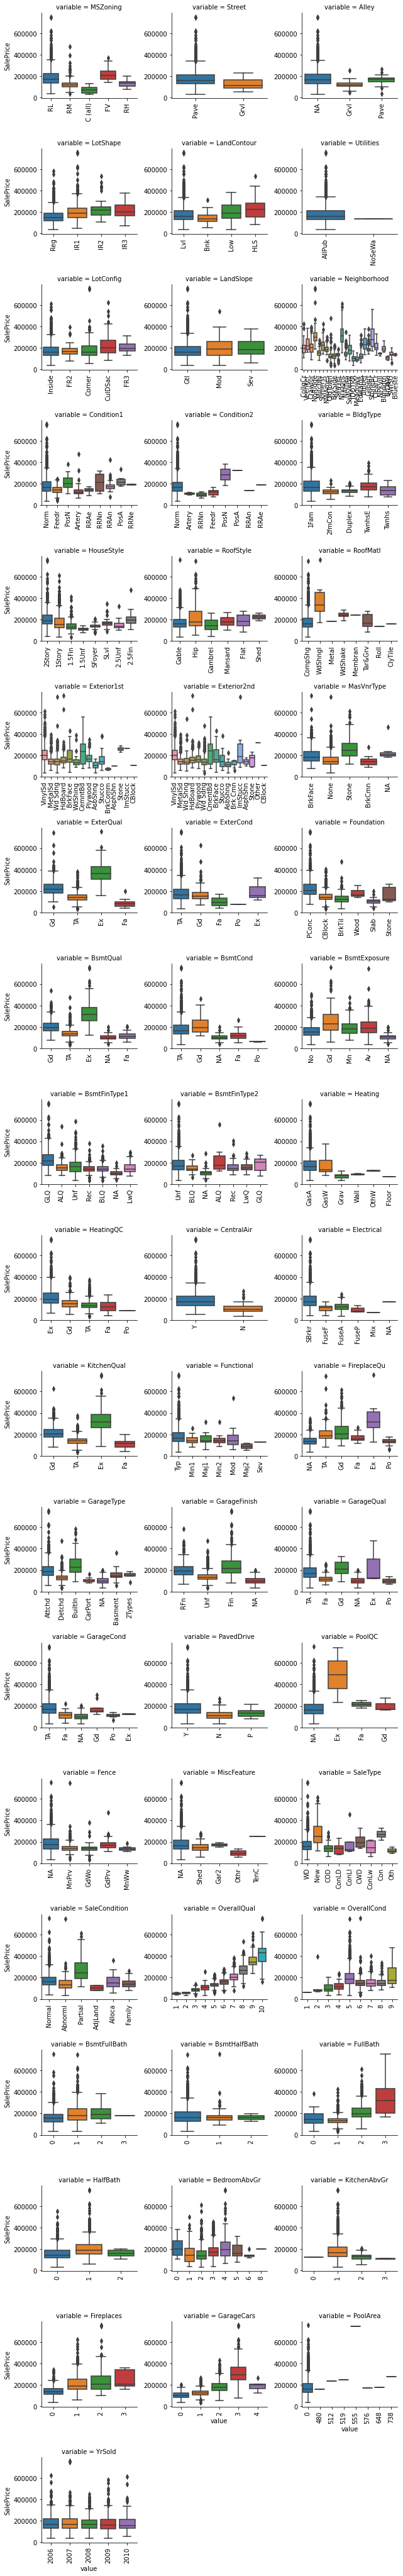

In [18]:
if PLOT:
    f = pd.melt(
        X.join(y).fillna("NA"),
        id_vars=["SalePrice"],
        value_vars=X.join(y).fillna("NA")[cat_cols],
    )
    g = sns.FacetGrid(
        f, col="variable", col_wrap=3, sharex=False, sharey=False, height=3
    )
    g.map(custom_boxplot, "value", "SalePrice")


## 2 Prepare data


### 2.1 Clean

To fix typos and some columns names i'll use the class FixTypos that perform the following modifications:

&emsp;&emsp;Exterior2nd.replace(**'Brk Cmn', 'BrkComm'**)\
&emsp;&emsp;Exterior2nd.replace(**'CmentBd', 'CemntBd'**)\
&emsp;&emsp;Exterior2nd.replace(**'Wd Shng', 'Wd Sdng'**)\
&emsp;&emsp;BldgType.replace(**'Twnhs', 'TwnhsI'**)\
&emsp;&emsp;BldgType.replace(**'2fmCon', '2FmCon'**)\
&emsp;&emsp;BldgType.replace(**'Duplex', 'Duplx'**)

, and rename columns:

&emsp;&emsp;**"1stFlrSF"** to **"FirstFlrSF"**\
&emsp;&emsp;**"2ndFlrSF"** to **"SecondFlrSF"**\
&emsp;&emsp;**"3SsnPorch"** to **"Threeseasonporch"**

In [19]:
fix_typos = FixTypos()


### 2.2 Categorize Data

Levels os each categorical column

In [20]:
# Unordered categorical columns
unordered_levels = {
    "MSSubClass": [20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190],
    "MSZoning": ["A", "C (all)", "FV", "I", "RH", "RL", "RP", "RM"],
    "Street": ["Grvl", "Pave"],
    "Alley": ["Grvl", "Pave", "None"],
    "LandContour": ["Lvl", "Bnk", "HLS", "Low"],
    "LotConfig": ["Inside", "Corner", "CulDSac", "FR2", "FR3"],
    "Neighborhood": [
        "Blmngtn",
        "Blueste",
        "BrDale",
        "BrkSide",
        "ClearCr",
        "CollgCr",
        "Crawfor",
        "Edwards",
        "Gilbert",
        "IDOTRR",
        "MeadowV",
        "Mitchel",
        "NAmes",
        "NoRidge",
        "NPkVill",
        "NridgHt",
        "NWAmes",
        "OldTown",
        "SWISU",
        "Sawyer",
        "SawyerW",
        "Somerst",
        "StoneBr",
        "Timber",
        "Veenker",
    ],
    "Condition1": [
        "Artery",
        "Feedr",
        "Norm",
        "RRNn",
        "RRAn",
        "PosN",
        "PosA",
        "RRNe",
        "RRAe",
    ],
    "Condition2": [
        "Artery",
        "Feedr",
        "Norm",
        "RRNn",
        "RRAn",
        "PosN",
        "PosA",
        "RRNe",
        "RRAe",
    ],
    "BldgType": ["1Fam", "2FmCon", "Duplx", "TwnhsE", "TwnhsI"],
    "HouseStyle": [
        "1Story",
        "1.5Fin",
        "1.5Unf",
        "2Story",
        "2.5Fin",
        "2.5Unf",
        "SFoyer",
        "SLvl",
    ],
    "RoofStyle": ["Flat", "Gable", "Gambrel", "Hip", "Mansard", "Shed"],
    "RoofMatl": [
        "ClyTile",
        "CompShg",
        "Membran",
        "Metal",
        "Roll",
        "Tar&Grv",
        "WdShake",
        "WdShngl",
    ],
    "Exterior1st": [
        "AsbShng",
        "AsphShn",
        "BrkComm",
        "BrkFace",
        "CBlock",
        "CemntBd",
        "HdBoard",
        "ImStucc",
        "MetalSd",
        "Other",
        "Plywood",
        "PreCast",
        "Stone",
        "Stucco",
        "VinylSd",
        "Wd Sdng",
        "WdShing",
    ],
    "Exterior2nd": [
        "AsbShng",
        "AsphShn",
        "BrkComm",
        "BrkFace",
        "CBlock",
        "CemntBd",
        "HdBoard",
        "ImStucc",
        "MetalSd",
        "Other",
        "Plywood",
        "PreCast",
        "Stone",
        "Stucco",
        "VinylSd",
        "Wd Sdng",
        "WdShing",
    ],
    "MasVnrType": ["BrkCmn", "BrkFace", "CBlock", "Stone", "None"],
    "Foundation": ["BrkTil", "CBlock", "PConc", "Slab", "Stone", "Wood"],
    "Heating": ["Floor", "GasA", "GasW", "Grav", "OthW", "Wall"],
    "CentralAir": ["N", "Y"],
    "GarageType": [
        "2Types",
        "Attchd",
        "Basment",
        "BuiltIn",
        "CarPort",
        "Detchd",
        "None",
    ],
    "MiscFeature": ["Elev", "Gar2", "Othr", "Shed", "TenC", "None"],
    "SaleType": [
        "WD",
        "CWD",
        "VWD",
        "New",
        "COD",
        "Con",
        "ConLw",
        "ConLI",
        "ConLD",
        "Oth",
    ],
    "SaleCondition": ["Normal", "Abnorml", "AdjLand", "Alloca", "Family", "Partial"],
}

# Ordered categorical columns
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
six_levels = ["None", "Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(1, 11))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": six_levels,
    "BsmtCond": six_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": six_levels,
    "GarageQual": six_levels,
    "GarageCond": six_levels,
    "PoolQC": ["None", "Fa", "TA", "Gd", "Ex"],
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["None", "No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["None", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["None", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["None", "Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["ELO", "NoSeWa", "NoSewr", "AllPub"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["None", "MnWw", "GdWo", "MnPrv", "GdPrv"],
}


Ordinal categorical will be encoded as ordered **category** dtype. Unordered categorical data w'll be encoded as **category**.

In [21]:
categorize_nominal = CategorizeNominal(ordered_levels, unordered_levels)


### 2.3 Missing Values

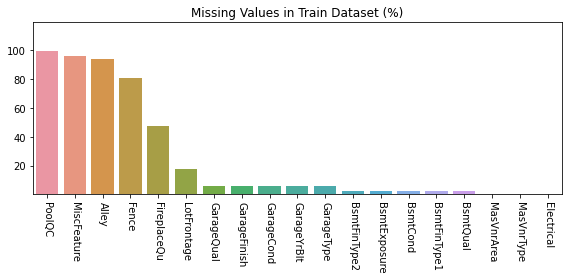

In [22]:
plot_relationship(get_missing(X, True), "Missing Values in Train Dataset (%)")


The dataset has some columns with considerable number os missing values:

&emsp;&emsp;__PoolQC, MiscFeature, Alley, Fence, FireplaceQu__ columns have more than 50 % of values missing.\
&emsp;&emsp;__Frontage__ has roughly 15 % of missing data.\
&emsp;&emsp;__Garage, Bsmt, and MasVnr__ have between 2% and 3% of missing data

Most data is missing because the feature **doesn't exist**, like a house that don't have Pool, Alley, Fence, Basement, or Garage, to fill these data i'll use the class FillWith(). These columns will be filled with **None**

&emsp;&emsp;missing_features = [**'PoolQC', 'MiscFeature','Alley', 'Fence', 'FireplaceQu'**]\
&emsp;&emsp;FillWith(missing_features, value=**'None'**)

The same occurs to Garage, MasVnr, and Bsmt data, bus it these, each feature has a set of columns, so i'll use the class FillByGroup(). This class use as parameter a column responsible for saying _whether_ the house has the feature or not, and a keyword used to find all columns corresponding to that feature (with similar names). These columns will be filled with '0' when numerical, and 'None' when categorical

&emsp;&emsp;FillByGroup(group_ref=**'GarageType'**, group_keyword=**'Garage'**, cat_value=**'None'**)\
&emsp;&emsp;FillByGroup(group_ref=**'BsmtCond'**, group_keyword=**'Bsmt'**, cat_value=**'None'**)\
&emsp;&emsp;FillByGroup(group_ref=**'MasVnrType'**, group_keyword=**'MasVnr'**, cat_value=**'None'**)

Finnaly, the remaining of the missing columns will be filled using the class FillByKNN()

&emsp;&emsp;FillByKNN(n_neighbors=1)



In [23]:
# Pipeline to fill missing data
missing_features = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"]

fill = make_pipeline(
    FillByGroup(group_ref="GarageType", group_keyword="Garage"),
    FillByGroup(group_ref="BsmtCond", group_keyword="Bsmt"),
    FillByGroup(group_ref="MasVnrType", group_keyword="MasVnr"),
    FillWith(missing_features),
    FillByKNN(n_neighbors=1),
)


## 3 Baseline

In [24]:
X_train, y_train = X.copy(), y.copy()


### 3.1 Base Pipeline

In [25]:
encoding = EncodeCategories()
convert_to_int = ConvertToInt()
base_pipeline = make_pipeline(fix_typos, categorize_nominal, fill, encoding)


### 3.2 Score Baseline Dataset

In [26]:
X_train_base = base_pipeline.fit_transform(X_train)
score_dataset(X_train_base, y_train)


0.13832382374749103

### 3.3 Uninformative Variables

In [27]:
mi_scores_base = make_mi_scores(X_train_base, y_train)
mi_scores_base[mi_scores_base == 0]


PoolQC     0.0
MiscVal    0.0
MoSold     0.0
Name: MI Scores, dtype: float64

**PoolQC, MiscVal**, and **MoSold** w'll be dropped from the dataset

In [28]:
drop_cols = DropCols(mi_scores_base[mi_scores_base == 0].index)
drop_cols


BuildPCA(cols=['PoolQC', 'MiscVal', 'MoSold'])

In [29]:
preprocessing = make_pipeline(fix_typos, categorize_nominal, fill, encoding, drop_cols)


### 3.4 Score dataset whitout uninformative variables

In [30]:
X_train_mi = preprocessing.fit_transform(X_train)
score_dataset(X_train_mi, y_train)


0.13688406070823442

## 4 Feature Engineering

Build some features can improve our model perfomance, let's test some new variables.

Create features by **Matematical** operations between other columns in the dataset.

**Interactions** will expand the relationship between each category in a column and the target variables.\
To avoid a name issue, which generates columns with names A_0 in the Train dataset, and A_0.0 in the test dataset,\
before I'll convert all 'float' columns to 'int'.

**Counts** features are columns generated by counting values from another column, or by counting features through other columns. 

Finnaly, **Group** features will group one features by another.

In [31]:
add_math_feat = BuildMathFeatures()
convert_to_int = ConvertToInt()
add_interactions_feat = BuildInteractionsFeatures()
add_count_feat = BuildCountsFeatures()
add_group_feat = BuildGroupFeatures()


### 4.1 Features Pipeline

In [32]:
add_features = make_pipeline(
    convert_to_int,
    # add_math_feat,
    add_interactions_feat,
    # add_count_feat,
    add_group_feat,
)
pipeline1 = make_pipeline(preprocessing, add_features)


### 4.2 Score dataset with new features

In [33]:
X_train_pipe1 = pipeline1.fit_transform(X_train)
score_dataset(X_train_pipe1, y_train)


0.13150758930112186

##  5 K-means clustering

We can group data points by similarity using clustering and use the clusters to see how much our model improves.
I'll use data from house characteristics like, roof style, roof material, mansory veneer type, foundation etc.

### 5.1 Search the best number of clusters

In [34]:
# variables = ["RoofStyle", "RoofMatl","Exterior2nd", "MasVnrType","ExterCond", "ExterQual", "Foundation"]
# find_best_k(X_train_pipe1, y_train, variables, 21)


Here are some scores found and variables that was used
|n_clusters| score | variables |
| --- | --- | --- |
| 4 | 0.1311091589695912 |["RoofStyle", "RoofMatl","MasVnrType"]|
|11 | 0.13068200867318205 | ["RoofStyle", "RoofMatl","Exterior1st" , "MasVnrType", "ExterCond", "ExterQual", "Foundation"] |
| 8 | 0.13036978405840366 |["RoofStyle", "RoofMatl","Exterior2nd", "MasVnrType","ExterCond", "ExterQual", "Foundation"] |

### 5.2 Create pipeline to add cluster

Using the class BuildCluster that add a cluster column to the data

In [35]:
variables = [
    "RoofStyle",
    "RoofMatl",
    "Exterior2nd",
    "MasVnrType",
    "ExterCond",
    "ExterQual",
    "Foundation",
]
add_cluster = BuildCluster(variables, 8, 50, name="Cluster1")
pipeline2 = make_pipeline(pipeline1, add_cluster)


### 5.3 Score dataset with clusters

In [36]:
X_train_pipe2 = pipeline2.fit_transform(X_train)
score_dataset(X_train_pipe2, y_train)


0.12960726587863944

## 6 Principal Component Analysis

PCA is a dimensionality-reduction method that helps to reduce the number of variables of a data set by transform _p_ variables into _k_ principal components, then often a _k_ < _p_ will store the most of the variation of _p_ variables.

When we have a large number of correlated variables in a data set, we can reduce to just a few principal componets with still explain the most of the variance of the original variables.

Also, because we just keep the principal components, the main of the information is kept, and the noise is removed.

A less number of variables transform makes our model more computationally efficient.

### 6.2 Selecting High correlated variables

In [37]:
## Thank you @mikkom from stackoverflow to that piece of code
corr = X_train_pipe2.corr().stack()

# Ignore autocorrelation
corr = corr[corr.index.get_level_values(0) != corr.index.get_level_values(1)]

# Select only highly correlated (ρ => 0.8)
high_corr = corr[corr > 0.8]
high_corr


Exterior1st        Exterior2nd          0.870791
Exterior2nd        Exterior1st          0.870791
TotalBsmtSF        FirstFlrSF           0.819530
FirstFlrSF         TotalBsmtSF          0.819530
GrLivArea          TotRmsAbvGrd         0.825489
BedroomAbvGr       BedRm_LvArea_mean    0.917690
TotRmsAbvGrd       GrLivArea            0.825489
Fireplaces         FireplaceQu          0.863241
FireplaceQu        Fireplaces           0.863241
GarageYrBlt        GarageQual           0.946629
                   GarageCond           0.949411
GarageCars         GarageArea           0.882475
GarageArea         GarageCars           0.882475
GarageQual         GarageYrBlt          0.946629
                   GarageCond           0.959172
GarageCond         GarageYrBlt          0.949411
                   GarageQual           0.959172
BedRm_LvArea_mean  BedroomAbvGr         0.917690
dtype: float64

In [38]:
# Parse to a list
high_corr_variables = high_corr.index.unique(level=0)


### 6.1 Create Pipeline to add PCA

With PCA we can either, substitute the original variables by computed PCA's and discard less informative variables, use loadings to inspire combination of variables. I choose the first option.

Passing a argument _drop_originals=True_, the transformed variables will be used instead of the original, and the _use_n_components=n_ will define the number of PCA used ( PC1, PC2,...,PCn)

In [39]:
add_pca = BuildPCA(high_corr_variables, drop_originals=True, use_n_components=6)
pipeline3 = make_pipeline(pipeline2, add_pca)


In [40]:
x_train_pipe3 = pipeline3.fit_transform(X_train)
score_dataset(x_train_pipe3, y_train)


0.13900169190319875

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

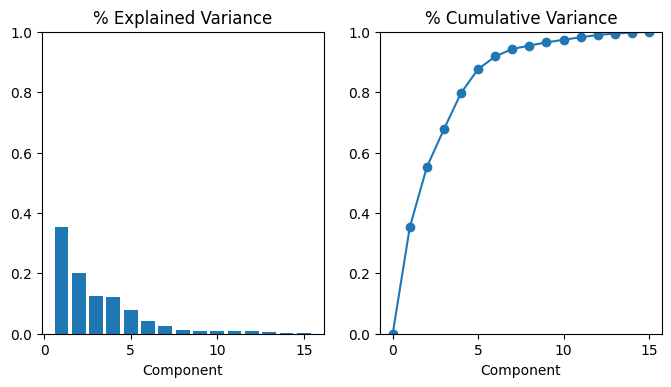

In [41]:
pca = pipeline3[1].get_pca()
plot_variance(pca)


This approach don't improve our model at all

## Parameter tunning

In [43]:
import optuna


def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 15),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 2000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train_pipe2, y_train, xgb)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=2)
xgb_params = study.best_params


[I 2021-12-03 00:16:03,675] A new study created in memory with name: no-name-d88d2d91-375a-48c7-955e-9655aa4fd60d
[I 2021-12-03 00:16:30,931] Trial 0 finished with value: 0.12591725875443596 and parameters: {'max_depth': 8, 'learning_rate': 0.09991323284577337, 'n_estimators': 1146, 'min_child_weight': 6, 'colsample_bytree': 0.94570928065169, 'subsample': 0.470140550127949, 'reg_alpha': 0.011154608142826093, 'reg_lambda': 15.856042832370184}. Best is trial 0 with value: 0.12591725875443596.
[I 2021-12-03 00:16:47,817] Trial 1 finished with value: 0.48051390240814035 and parameters: {'max_depth': 4, 'learning_rate': 0.001697128540063476, 'n_estimators': 1912, 'min_child_weight': 8, 'colsample_bytree': 0.29878660442752114, 'subsample': 0.44147414966409493, 'reg_alpha': 0.0033229157190151105, 'reg_lambda': 0.4165909997909545}. Best is trial 0 with value: 0.12591725875443596.


The substitution of variables by principal components don't improve our model at all.

In [44]:
xgb_model = XGBRegressor(**xgb_params)
model_score = score_dataset(X_train_pipe2, y_train, xgb_model)
model_score


0.12591725875443596

In [46]:
X_test_pipe2 = pipeline2.transform(X_test)
xgb_model.fit(X_train_pipe2, y_train)
y_pred = xgb_model.predict(X_test_pipe2)


In [47]:
generate_submission_file(X_test_pipe2, y_pred, model_score)
